In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys,os, re
import pandas as pd
from functools import partial
import itertools
import json, glob
from math import comb
from scipy.optimize import minimize
    
repobase="/Users/rosamartinezcorral/OneDrive - CRG - Centre de Regulacio Genomica/papers/github_repos/MPRAfitting/"
sys.path.append(os.path.join(repobase,"bin"))
from functions_fractional_occupancy import fi_1sites, fi_2sites, fi_3sites, fi_4sites, fi_5sites, fi_6sites
from biophysmodel_utils import logfoldchange_from_avbinding_ratesdirectly_Hill, get_S_max
from utils_fit import run_genetic, get_parsetnames_affinitiesdirect
from utils_fit import dataframe_from_bestpars
fifunctions={1:fi_1sites, 2:fi_2sites, 3:fi_3sites,4:fi_4sites,5:fi_5sites,6:fi_6sites}

In [3]:
def plot_best_input_output(best,args_fitnessfunction=None):
    #best is the parameter set to be plotted
    
    ncol=1
    error,arv=error_input_output(best,**args_fitnessfunction)
    #display(out)
    xvals=args_fitnessfunction["data"][:,0]
    fig,ax=plt.subplots(1,ncol,figsize=(5,4),sharey=True)
    
    yvalsoccupancy=arv[:,0]
    yvalsGFP=arv[:,1]
    ymodelvals=arv[:,2]
    ax.scatter(xvals, np.exp(yvalsGFP),c="k")
    ax.plot(xvals,np.exp(ymodelvals),color="k")
    print("ymodelvals", np.exp(ymodelvals))
    ax2=ax.twinx()
    ax2.plot(xvals,yvalsoccupancy,marker="o")
    ax.set_xlabel("ZF")
    ax.set_ylabel("fold change GFP")
    ax2.set_ylabel("occupancy")
    plt.tight_layout()
    plt.show()

In [4]:
def error_input_output(individual,otherpars=[],coop=False,rates_affected=[],logfcfunction=None, evaluate_parset=None,
                   data=None,  means=[],
                   idx1=0, idx2=0, idx3=0, plot=False,plotparset=False,nrow=1,ncol=1,parsetnames=[],outerror="inverse",individualerror=False,fitonlyKs=False):
    #afcat_idxs:list of lists, each list hast the idxs of the rows that correspond to the same affinity
    ar=np.asarray(individual)
    if fitonlyKs:
        global_occupancy_pars=ar
        global_occupancy_pars_discard=otherpars[0:idx1] #note that now the TF concentration is for each condition, because conditions correspond to celltypes
        globalcyclepars=otherpars[idx1:idx2]
        globalTFcyclepars=otherpars[idx2:idx3]
    else:
        global_occupancy_pars=ar[0:idx1] #note that now the TF concentration is for each condition, because conditions correspond to celltypes
        globalcyclepars=ar[idx1:idx2]
        globalTFcyclepars=ar[idx2:idx3]
    TFcyclepars=globalTFcyclepars
    occupancy_pars=global_occupancy_pars
    values_data_model=[]
    K=np.exp(occupancy_pars[0]) #now only one affinity
    for i in range(len(data)):
        input_,value=data[i]
        Kx=K*input_
        fi=Kx/(1+Kx)
        output=logfcfunction(globalpars=globalcyclepars,TFpars=TFcyclepars,avbinding=fi,rates_affected=rates_affected)
        values_data_model.append([fi,value,output])
    arv=np.asarray(values_data_model)
    total_error=np.sum(np.abs(np.diff(arv[:,1:],axis=1)))
    
    return [total_error,arv]


In [5]:
outfolder="2025_01_10_Sp1fitZF"
rates_affected=[0,1,2,3]
if not os.path.isdir(outfolder):
    os.mkdir(outfolder)
# Genetic Algorithm parameters:
POPULATION_SIZE = 300 #500
MAX_GENERATIONS = 100

MUTSIGMA=0.25 #sigma
INDPB=0.5

P_CROSSOVER = 0.25  # probability for crossover
P_MUTATION = 0.5  # probability for mutating an individ
ETACXBIN=0.25

coop=False


parsetnames,idxs=get_parsetnames_affinitiesdirect(naffinities=2,rates_affected=rates_affected,nconditions=1) #using naffinities2 but actually it is only 1. Doing this so I get the right indices and parsetnames
parsetnames=parsetnames[:-1] #remove the last one, which is the concentration
print(parsetnames,idxs)


['Kaf1', 'k_1', 'k_m1', 'k_2', 'k_3', 'K_r0', 'n_r0', 'fc_r0', 'K_r1', 'n_r1', 'fc_r1', 'K_r2', 'n_r2', 'fc_r2', 'K_r3', 'n_r3', 'fc_r3'] [1, 5, 17, [17, 18]]


In [6]:
meanGFP=np.log(np.array([1.198925, 2.400825, 3.185065,1.92613 ]))
meanZF=np.array([ 1.,         1.32350962, 11.07622745, 14.16303113])
data=np.array([meanZF,meanGFP])
data=data.transpose()
data

array([[ 1.        ,  0.18142532],
       [ 1.32350962,  0.87581243],
       [11.07622745,  1.1584727 ],
       [14.16303113,  0.65551281]])

In [7]:
np.random.uniform(0,0)

0.0

In [10]:
idx1,idx2,idx3,idxs_conditions=idxs #we will not use idxs_conditions here
MINV_7=-10
MAXV_7=10
MINV_3=-3 #20
MAXV_3=2 #0.05
jid=1

#get bounds
bounds=[]
for name in parsetnames:
    if name.startswith("Kaf"):
        bounds.append([-4,4])
    elif name.startswith("n"):
        bounds.append([0,1])
    elif name.startswith("fc"):
        bounds.append([-6,6])
    else:
        bounds.append([-5,5])
print("bounds:",bounds)
for x in zip(parsetnames,bounds):
    print(x)

args_fitnessfunction={"logfcfunction":logfoldchange_from_avbinding_ratesdirectly_Hill,
      "idx1":idx1, "idx2":idx2, "idx3":idx3,"coop":coop,"rates_affected":rates_affected,
      "data":data,
     "outerror":"inverse", "individualerror":False}
error_partial=partial(error_input_output,**args_fitnessfunction)
def fitnessfunc(pars):
    return error_partial(pars)[0],

plotbestpartial=partial(plot_best_input_output,args_fitnessfunction=args_fitnessfunction)

pars_genetic={"POPULATION_SIZE":POPULATION_SIZE, "MAX_GENERATIONS": MAX_GENERATIONS, 
              "P_CROSSOVER": P_CROSSOVER,"P_MUTATION": P_MUTATION, "MUTSIGMA": MUTSIGMA, "INDPB": INDPB,
              "HALL_OF_FAME_SIZE": 5,
             "fitnessfunc": fitnessfunc,
             "seeds":np.arange(100),
              "cxbin":True,
              "TOURNSIZE":10,
              "etacxbin":ETACXBIN,
              "plot_fitness_evo":True, 
              "plotintermediates":True, 
              "plotbest":False, "plotbestfunc":plotbestpartial, "bounds":bounds}

#best=run_genetic(**pars_genetic)
print("best")
print(best)
fitness,parset,seed,refined=best
best_condition={"jid":jid,"seed":int(seed),"fitness":fitness,"parset":",".join(list(map(str,parset))),"refined":refined}
with open("./%s/best_%d.json"%(outfolder,jid), "w") as outfile: 
    json.dump(best_condition, outfile)

bounds: [[-4, 4], [-5, 5], [-5, 5], [-5, 5], [-5, 5], [-5, 5], [0, 1], [-6, 6], [-5, 5], [0, 1], [-6, 6], [-5, 5], [0, 1], [-6, 6], [-5, 5], [0, 1], [-6, 6]]
('Kaf1', [-4, 4])
('k_1', [-5, 5])
('k_m1', [-5, 5])
('k_2', [-5, 5])
('k_3', [-5, 5])
('K_r0', [-5, 5])
('n_r0', [0, 1])
('fc_r0', [-6, 6])
('K_r1', [-5, 5])
('n_r1', [0, 1])
('fc_r1', [-6, 6])
('K_r2', [-5, 5])
('n_r2', [0, 1])
('fc_r2', [-6, 6])
('K_r3', [-5, 5])
('n_r3', [0, 1])
('fc_r3', [-6, 6])
best


NameError: name 'best' is not defined

Kaf1 0.02510799300626393
k_1 0.018753325357776726
k_m1 0.07458500560578807
k_2 1.7075518390124278
k_3 0.5147966120399581
K_r0 0.05462225564910161
n_r0 2.718268614482051
fc_r0 148.39130381240892
K_r1 0.006737948338172179
n_r1 2.71828112017846
fc_r1 380.89538371469155
K_r2 0.1125415516305991
n_r2 2.3600837664917704
fc_r2 10.85788170290818
K_r3 0.09762121198388013
n_r3 2.7158427413734443
fc_r3 0.0029621366446563667
[('Kaf1', -3.684569037073014), ('k_1', -3.976384189876039), ('k_m1', -2.5958157892165215), ('k_2', 0.5350606715992872), ('k_3', -0.6639833844007836), ('K_r0', -2.9073138666618257), ('n_r0', 0.9999951388377124), ('fc_r0', 4.9998527293694135), ('K_r1', -4.99999980126193), ('n_r1', 0.9999997394381002), ('fc_r1', 5.942524753995763), ('K_r2', -2.184432777702233), ('n_r2', 0.8586971126837858), ('fc_r2', 2.384891240499262), ('K_r3', -2.3266604732767044), ('n_r3', 0.9991023072003402), ('fc_r3', -5.821844431635997)]
ymodelvals [1.19892499 2.38762758 2.95530254 1.9271689 ]


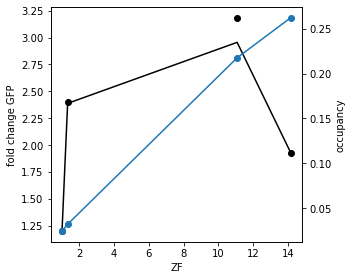

In [11]:
bestparsetar=np.array([-3.684569037073014,-3.976384189876039,-2.5958157892165215,0.5350606715992872,-0.6639833844007836,-2.9073138666618257,0.9999951388377124,4.9998527293694135,-4.99999980126193,0.9999997394381002,5.942524753995763,-2.184432777702233,0.8586971126837858,2.384891240499262,-2.3266604732767044,0.9991023072003402,-5.821844431635997])
for i in range(len(bestparsetar)):
    print(parsetnames[i],np.exp(bestparsetar[i]))
print(list(zip(parsetnames,bestparsetar)))
plot_best_input_output(bestparsetar,args_fitnessfunction)


In [11]:
np.exp(1)

7.38905609893065